# Applied Data Science Capstone Final Project
# Cluster Comparison of Multiple Cities
### Richard C. Anderson

## Sections
-  <a href='#section1'>Introduction & Description</a>
-  <a href='#section2'>Data Requirements & Acquisition</a>
-  <a href='#section3'>Methodology & Analysis</a>
-  <a href='#section4'>Results</a>
-  <a href='#section5'>Recommendations</a>
-  <a href='#section6'>Conclusion</a>

## <a id='section1'></a>    1. Introduction & Description

While I worked through the New York and Toronto clustering exercises for the Applied Data Science course , I found myself wondering how a K-means clustering analysis of the neighborhood venues of New York's Manhattan would compare with the neighborhood venues of the Boston metro area, where I now live in the suburbs, and with central Houston, where I have lived in the past.

Would a K-means clustering analysis pick up on what I know subjectively about the three cities? I would expect Boston and Manhattan neighborhoods to be similar, as both cities are older, denser, pre-date the automobile, and have extensive mass-transit options. Houston, on the other hand, has developed entirely with the automobile as its primary transportation method and, in part due to cheaper land prices, has a much lower population density. Houston's central downtown is all business and mostly deserted after 8pm as very few people live there. Its mass transit system is mostly bussing with an emphasis on workers commuting to and from the downtown area.

The central question is whether venues in the Houston neighborhoods will cluster with those of Boston and Manhattan. I theorize that Houston might contain mostly independent venue clusters while Boston and Manhattan share similar cluster types. This study will perform multiple K-means investigations. First, the project will replicate the Manhattan neighborhoods venue clustering evaluation from the course exercises and develop new venue clustering evaluations for Boston and Houston neighborhoods. Second, the Manhattan, Boston, and Houston neighborhood venue data will be aggregated for a multi-city K-means venue clustering evaluation. The multi-city evaluation will compare the neighborhood venues of the older cites of Manhattan and Boston with the much newer Houston.

The multi-city evaluation performed for this study project is an approach that has potential marketing and operational benefits for businesses. For instance, a venue evaluation can help locate both saturated and underserved market areas. For a business considering opening into to completely new markets, the multi-city evaluation can provide clues for new site location as well as how a business might need to adapt its product offerings to compensate for differences in predominate neighborhood characteristics. The multi-city evaluation approach could also be useful for more personal use as well. As an example, someone relocating from one city to another could start by determining which neighborhoods in a new city most resemble (or differ!) from their current neighborhood.

## <a id='section2'></a>   2. Data Requirements & Acquisition
### Data Requirements

This project will require the following information for the neighborhoods of Manhattan, the Boston metro area, and central Houston:
-  List of neighborhoods
-  Geo-location data for each neighborhood
-  Set of venues for each neighborhood

### Data Sources

The neighborhood list and geo-location data for Manhattan will come from the json dataset that was used for the earlier course exercises.  Unfortunately, a google search for tabular data of Boston and Houston neighborhoods and their geo-locations did not yield any directly usable results. However, it was possible to use Wikipedia to manually construct CSV files with neighborhood and geo-location information. Foursquare will be used for gathering the venue data for the city neighborhoods.

### Data Acquisition

The manual construction of neighborhood names and geo-locations for Boston and Houston required several subjective judgements, as there did not appear to be a single definitive neighborhood list on Wikipedia and other websites for either Boston or Houston. I used my personal familiarity with both cities to determine suitable neighborhood lists.

Another issue for compiling the neighborhood lists for Boston and central Houston is how to define their metro area boundaries for comparison with the borough of Manhattan. Central Houston is typically defined as the neighborhoods inside the 610 Loop freeway. However, there are two independent cities, Bellaire and West University Place, that are fully contained in this area and will be included as part of central Houston. Also, I chose include the first ring of neighborhoods just outside the 610 Loop as part of central Houston for the purpose of this study. I made this decision in part to give each metro area approximately the same number of neighborhoods. Defining the Boston metro area also required some subjective adjustments as there are independent major suburbs, particularly Brookline, Cambridge, and Somerville that are sufficiently close enough to Boston to be considered part of its central metro area.

Foursquare was used for gathering the venue data for all neighborhoods. However, the developmental differences between Houston and the older cities of Boston and Manhattan had an impact on the queries used for gathering the venue data. In the original course exercise for Manhattan the venues were pulled from Foursquare using a 500-meter radius around the center geo-location of each neighborhood. The population density differences between the three cities suggested that a different radius setting would be required for each city to gather sufficient venue data.

Iterative venue count evaluations were made for Boston and Houston to determine reasonable radius settings. At the initial setting of 500 meters, many Boston neighborhoods and most Houston neighborhoods returned less than 20 venues within a neighborhood. Houston, using the initial 500-meter radius setting, had several neighborhoods that returned fewer than 5 venues. The search radius for both Boston and Houston were increased until each city had a least 10 neighborhoods that returned 100 venues (max limit) and the sparser neighborhoods returned 10 venues. As suspected, Houston required a much larger search radius to obtain reasonable venue lists.

The search radius settings used to acquire the venue information were set as follows:

    Manhattan:       500 meters
    Boston Metro:    1000 meters
    Central Houston: 2500 meters


### Data Cleaning

Two adjustments were made to clean the raw neighborhood and venue data.

First, during the aggregation of the neighborhood geo-location data with the venue data, it was discovered that both Houston and Boston return results for a venue category called ‘Neighborhood’, causing some interesting conflicts with the ‘Neighborhood’ name column in the geo-location data. Subsequently, the ‘Neighborhood’ venue results were filtered out of the Foursquare data prior to joining it with the geo-location data.

Second, during the K-means clustering analysis of Houston, one neighborhood always formed a cluster of one, no matter how few or many clusters were chosen for the K-means evaluation. The outlier neighborhood had only 10 venues returned at the search radius of 2500 meters. Further investigation revealed that the neighborhood was extremely industrial, with little residential or commercial presence. Therefore, the neighborhood was removed from the Houston neighborhood list.

#### Install and import python libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import json
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import types
from botocore.client import Config
import ibm_boto3

print('Libraries imported.')

Libraries imported.


In [2]:
!pip install geopy
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
print('geopy imported')

geopy imported


In [3]:
!pip install folium==0.5.0
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if folium not previously installed
import folium # map rendering library
print('folium imported')

     |████████████████████████████████| 81kB 3.5MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/f8/98/ff/954791afc47740d554f0d9e5885fa09dd60c2265d42578e665
Successfully built folium
folium imported


### 2.1 Create Neighborhood Geolocation Dataframes

The following sections will create the Manhattan, Boston Metro, and Central Houston geolocation dataframes from their source data files. The neighborhood geolocation data is used to create folium map plots for visually evaluating the neighborhood data.

#### 2.1.1 NYC and Manhattan neighborhood geolocation datasets

In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('NY neighborhoods dataset downloaded')

NY neighborhoods dataset downloaded


In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_ny_hoods = pd.DataFrame(columns=column_names)

In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_ny_hoods = df_ny_hoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
print('The New York City dataframe contains {} boroughs and {} neighborhoods.'.format(
        len(df_ny_hoods['Borough'].unique()), df_ny_hoods.shape[0])
)
df_ny_hoods.head()

The New York City dataframe contains 5 boroughs and 306 neighborhoods.


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
df_manhattan_hoods = df_ny_hoods[df_ny_hoods['Borough'] == 'Manhattan'].reset_index(drop=True)
print('The Manhattan dataframe contains {} neighborhoods.'.format(df_manhattan_hoods.shape[0]))
df_manhattan_hoods.head()

The Manhattan dataframe contains 40 neighborhoods.


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [10]:
def __iter__(self): return 0

#### 2.1.2 Boston metro neighborhood geolocation dataset

In [11]:
# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_c579e19718a54ab9a82d7c9ca0a9f1c6 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='mp4LEJi4lI6Xx5OZCBoAucp6YCOyhmTj_4QpFcfFjob2',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_c579e19718a54ab9a82d7c9ca0a9f1c6.get_object(Bucket='courseradatasciencecapstoneprojec-donotdelete-pr-o9sutjrlk6n7po',Key='BostonMetroNeighborhoodsGeolocations.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_boston_hoods = pd.read_csv(body)
print('The Boston metro dataframe contains {} neighborhoods.'.format(df_boston_hoods.shape[0]))
df_boston_hoods.head()

The Boston metro dataframe contains 50 neighborhoods.


,Neighborhood,Latitude,Longitude
0,Allston,42.352900,-71.132100
1,Back Bay,42.351294,-71.080356
2,Bay Village (South Cove),42.349100,-71.068000
3,Beacon Hill,42.358300,-71.066100
4,Brighton,42.350000,-71.160000


#### 2.1.3 Central Houston neighborhood geolocation dataset 

In [12]:
body = client_c579e19718a54ab9a82d7c9ca0a9f1c6.get_object(Bucket='courseradatasciencecapstoneprojec-donotdelete-pr-o9sutjrlk6n7po',Key='HoustonNeighborhoodsGeolocations2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_houston_hoods = pd.read_csv(body)
print('The Central Houston dataframe contains {} neighborhoods.'.format(df_houston_hoods.shape[0]))
df_houston_hoods.head()

The Central Houston dataframe contains 49 neighborhoods.


,Neighborhood,Latitude,Longitude
0,Central Northwest,29.832700,-95.444800
1,Indepence Heights,29.828400,-95.397700
2,Lazybrook / Timbergrove,29.801600,-95.438100
3,Greater Heights,29.798056,-95.398056
4,Greater Uptown,29.746111,-95.463889


#### The El Dorado / Oates Prairie neighnorhood is an outlier in every analyis as it appears to be an entirely industrial area. Therefore, I decided to drop this neighborhood from the Central Houston dataframe

In [13]:
indexNames = df_houston_hoods[ df_houston_hoods['Neighborhood'] == 'El Dorado / Oates Prairie' ].index
df_houston_hoods.drop(indexNames , inplace=True)
df_houston_hoods.reset_index(drop=True, inplace=True)
print('The revised Central Houston dataframe contains {} neighborhoods.'.format(df_houston_hoods.shape[0]))
df_houston_hoods.head()

The revised Central Houston dataframe contains 48 neighborhoods.


,Neighborhood,Latitude,Longitude
0,Central Northwest,29.832700,-95.444800
1,Indepence Heights,29.828400,-95.397700
2,Lazybrook / Timbergrove,29.801600,-95.438100
3,Greater Heights,29.798056,-95.398056
4,Greater Uptown,29.746111,-95.463889


#### 2.1.4 Combined Metros neighborhood geolocation dataset

In [14]:
df_manhattan_metro_hoods = df_manhattan_hoods.copy()
df_manhattan_metro_hoods.rename(columns={'Borough': 'MetroArea'}, inplace=True)
df_boston_metro_hoods = df_boston_hoods.copy()
df_boston_metro_hoods.insert(0, 'MetroArea', 'Boston Metro')
df_houston_metro_hoods = df_houston_hoods.copy()
df_houston_metro_hoods.insert(0, 'MetroArea', 'Central Houston')

In [15]:
df_combined_hoods = pd.concat([df_manhattan_metro_hoods, df_boston_metro_hoods, df_houston_metro_hoods])
df_combined_hoods.head()

,MetroArea,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


### 2.2 Plot City Neighborhoods
#### Folium Map setup

In [16]:
def getAddressGeolocation(address):
    geolocator = Nominatim(user_agent="geo_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    #print('The geograpical coordinates of {} are {}, {}.'.format(address,latitude, longitude))
    
    return (latitude, longitude)

In [17]:
city_addresses = ['Manhattan, NY', 'Boston, MA', 'Houston, TX', 'New York City, NY']
#city_addresses = ['New York City, NY', 'Boston, MA', 'Houston, TX']
city_geoloc = []
for index, address in enumerate(city_addresses):
    # print(index, address)
    geoloc = getAddressGeolocation(address)
    city_geoloc.append([address,geoloc])
    # print('The geograpical coordinates of {} are lat: {}, long: {}.'.format(city_geoloc[index][0], city_geoloc[index][1][0], city_geoloc[index][1][1]))

city_geoloc

[['Manhattan, NY', (40.7896239, -73.9598939)],
 ['Boston, MA', (42.3602534, -71.0582912)],
 ['Houston, TX', (29.7589382, -95.3676974)],
 ['New York City, NY', (40.7127281, -74.0060152)]]

In [18]:
map_width = 250
map_height = 250
fig_width = map_width
fig_height = map_height
initial_zoom = 10

In [19]:
def createHoodMap(city_hoods_df,city_geoloc):
    # create city neighborhood map
    fig_hoods = folium.Figure(width=fig_width, height=fig_height)
    map_hoods = folium.Map(location=[city_geoloc[1][0], city_geoloc[1][1]], zoom_start=initial_zoom, width=map_width, height=map_height)

    # add neighborhood markers to map
    for lat, lng, label in zip(city_hoods_df['Latitude'], city_hoods_df['Longitude'], city_hoods_df['Neighborhood']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_hoods)
    
    fig_hoods.add_child(map_hoods)
    return fig_hoods

#### 2.2.1 Manhattan Neighborhoods

In [20]:
fig_manhattan = createHoodMap(df_manhattan_hoods,city_geoloc[0])
fig_manhattan

#### 2.2.2 Boston Metro Neighborhoods

In [21]:
fig_boston = createHoodMap(df_boston_hoods,city_geoloc[1])
fig_boston

#### 2.2.3 Central Houston Neighborhoods
Note that the neighborhood density is lower than Manhattan and Boston.

In [22]:
fig_houston = createHoodMap(df_houston_hoods,city_geoloc[2])
fig_houston

#### 2.2.4 NYC Neighborhoods

In [23]:
initial_zoom=9
fig_nyc = createHoodMap(df_ny_hoods,city_geoloc[3])
fig_nyc

#### Foursquare venue exploration setup

In [24]:
# @hidden_cell
CLIENT_ID = 'NAE2KEGTXHYPOXDP23T5PUOJHXKUPTSSZV4AWVZ5YUE0KWPW'
CLIENT_SECRET = 'CYT3A5YVLCSMMGYOKAQZMYJDSG2WGWSKRN12PJ4PZPCAGU43'
VERSION = '20180605'

In [25]:
search_limit = 100
manhattan_search_radius = 500

In [26]:
def getNeighborhoodVenues(names, latitudes, longitudes, search_radius):
    counter=0
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, search_radius, search_limit)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(name, lat, lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        counter+=1
        if counter % 5 == 0: print(counter,' neighbohoods searched...')

    hood_venues_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    hood_venues_df.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                  'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    hood_venues_filtered_df = hood_venues_df[hood_venues_df['Venue Category'] != 'Neighborhood'] # To eliminate rows with Venue Category set to 'Neighborhood'
    
    return(hood_venues_filtered_df)

### 2.3 Create Venue Dataframes
#### 2.3.1 Manhattan Neighborhood Venues

In [27]:
df_manhattan_venues = getNeighborhoodVenues(names=df_manhattan_hoods['Neighborhood'],
                                   latitudes=df_manhattan_hoods['Latitude'], longitudes=df_manhattan_hoods['Longitude'], search_radius=manhattan_search_radius)
print('Manhattan neighborhoods returned {} venues.'.format(df_manhattan_venues.shape[0]))

5  neighbohoods searched...
10  neighbohoods searched...
15  neighbohoods searched...
20  neighbohoods searched...
25  neighbohoods searched...
30  neighbohoods searched...
35  neighbohoods searched...
40  neighbohoods searched...
Manhattan neighborhoods returned 3088 venues.


In [28]:
df_manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In [29]:
print('Manhattan venue counts with search radius: ',manhattan_search_radius,' meters.')
df_val_counts = pd.DataFrame(df_manhattan_venues['Neighborhood'].value_counts())
ax = df_val_counts.sort_values('Neighborhood', ascending=True).plot.barh(y='Neighborhood',figsize=(10,10))

Manhattan venue counts with search radius:  500  meters.


#### 2.3.2 Boston Metro Neighborhood Venues

In [30]:
boston_search_radius = 1000
df_boston_venues = getNeighborhoodVenues(names=df_boston_hoods['Neighborhood'],
                                   latitudes=df_boston_hoods['Latitude'], longitudes=df_boston_hoods['Longitude'], search_radius=boston_search_radius)
print('Boston metro neighborhoods returned {} venues.'.format(df_boston_venues.shape[0]))

5  neighbohoods searched...
10  neighbohoods searched...
15  neighbohoods searched...
20  neighbohoods searched...
25  neighbohoods searched...
30  neighbohoods searched...
35  neighbohoods searched...
40  neighbohoods searched...
45  neighbohoods searched...
50  neighbohoods searched...
Boston metro neighborhoods returned 3925 venues.


In [31]:
df_boston_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Allston,42.3529,-71.1321,Fish Market Sushi Bar,42.353039,-71.132975,Sushi Restaurant
1,Allston,42.3529,-71.1321,Tous les Jours,42.351753,-71.131665,Bakery
2,Allston,42.3529,-71.1321,BonChon Chicken,42.353105,-71.130921,Fried Chicken Joint
3,Allston,42.3529,-71.1321,Mala Restaurant,42.352960,-71.131033,Chinese Restaurant
4,Allston,42.3529,-71.1321,Azama Grill,42.354422,-71.132358,Falafel Restaurant


Metro Boston venue counts with search radius:  1000  meters.


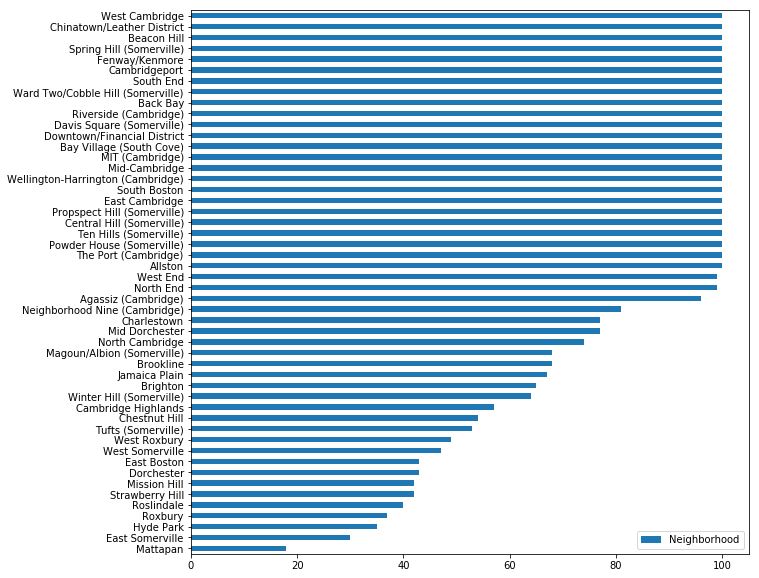

In [32]:
print('Metro Boston venue counts with search radius: ',boston_search_radius,' meters.')
df_val_counts = pd.DataFrame(df_boston_venues['Neighborhood'].value_counts())
ax = df_val_counts.sort_values('Neighborhood', ascending=True).plot.barh(y='Neighborhood',figsize=(10,10))

#### 2.3.3 Central Houston Neighborhood Venues

In [36]:
houston_search_radius = 2500
df_houston_venues = getNeighborhoodVenues(names=df_houston_hoods['Neighborhood'],
                                   latitudes=df_houston_hoods['Latitude'], longitudes=df_houston_hoods['Longitude'], search_radius=houston_search_radius)
print('Central Houston neighborhoods returned {} venues.'.format(df_houston_venues.shape[0]))

5  neighbohoods searched...
10  neighbohoods searched...
15  neighbohoods searched...
20  neighbohoods searched...
25  neighbohoods searched...
30  neighbohoods searched...
35  neighbohoods searched...
40  neighbohoods searched...
45  neighbohoods searched...
Central Houston neighborhoods returned 3718 venues.


In [38]:
df_houston_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Northwest,29.8327,-95.4448,Mytiburger,29.832268,-95.450974,Burger Joint
1,Central Northwest,29.8327,-95.4448,T C Jester Park,29.828376,-95.457260,Park
2,Central Northwest,29.8327,-95.4448,Plonk! Beer & Wine Bistro,29.829114,-95.431201,Wine Bar
3,Central Northwest,29.8327,-95.4448,Tacos A Go-Go,29.817542,-95.446720,Taco Place
4,Central Northwest,29.8327,-95.4448,European Wax Center,29.828911,-95.430725,Health & Beauty Service


Central Houston venue counts with search radius:  2500  meters.


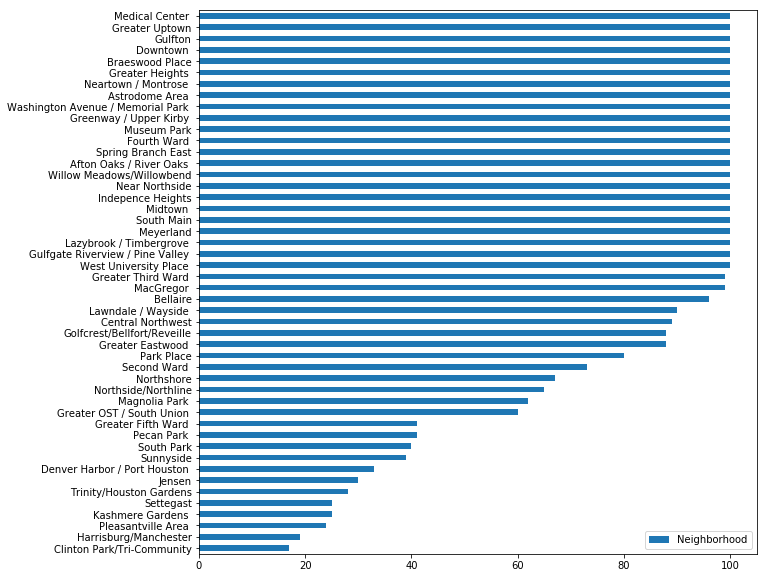

In [39]:
print('Central Houston venue counts with search radius: ',houston_search_radius,' meters.')
df_val_counts = pd.DataFrame(df_houston_venues['Neighborhood'].value_counts())
ax = df_val_counts.sort_values('Neighborhood', ascending=True).plot.barh(y='Neighborhood',figsize=(10,10))

## 3. <a id='section3'></a>  Methodology & Analysis
### 3.1 Combined Venue Data

In [40]:
df_manhattan_metro_venues = df_manhattan_venues.copy()
df_manhattan_metro_venues.insert(1, 'MetroArea', 'Manhattan')
df_boston_metro_venues = df_boston_venues.copy()
df_boston_metro_venues.insert(1, 'MetroArea', 'Boston Metro')
df_houston_metro_venues = df_houston_venues.copy()
df_houston_metro_venues.insert(1, 'MetroArea', 'Central Houston')

In [41]:
df_combined_venues = pd.concat([df_manhattan_metro_venues, df_boston_metro_venues, df_houston_metro_venues])
df_combined_venues.head()

,Neighborhood,MetroArea,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,Manhattan,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,Manhattan,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,Manhattan,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,Manhattan,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,Manhattan,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In [42]:
print('                 Unique     Venue\n               Categories   Count')
print('Manhattan:        {}        {}'.format(len(df_manhattan_venues['Venue Category'].unique()),df_manhattan_venues.shape[0]))
print('Boston Metro:     {}        {}'.format(len(df_boston_venues['Venue Category'].unique()),df_boston_venues.shape[0]))
print('Central Houston:  {}        {}'.format(len(df_houston_venues['Venue Category'].unique()),df_houston_venues.shape[0]))
print('Combined:         {}        {}'.format(len(df_combined_venues['Venue Category'].unique()),df_combined_venues.shape[0]))

                 Unique     Venue
               Categories   Count
Manhattan:        329        3088
Boston Metro:     300        3925
Central Houston:  276        3718
Combined:         433        10731


### 3.2 Neighborhood Venue Grouping

In [43]:
def toNeighborhoodVenueFrequency(df_venues,area_columns):
    df_hoods = pd.DataFrame()
    df_hoods[area_columns] = df_venues[area_columns]                                    # create neighborhood name dataframe with metro area columns
    df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="") # one hot encoding of venue data
    df_concat = pd.concat([df_hoods, df_onehot], axis=1, sort=False)                    # join one hot venue data to metro area columns
    df_grouped = df_concat.groupby(area_columns).mean().reset_index()                   # group by metro area columns
    return df_grouped

#### 3.2.1 Manhattan Neighborhood Venue Grouping Dataframe

In [44]:
df_manhattan_grouped = toNeighborhoodVenueFrequency(df_manhattan_venues,['Neighborhood'])
print(df_manhattan_grouped.shape)
df_manhattan_grouped.head()

(40, 330)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shoppin

#### 3.2.2 Boston Metro Neighborhood Venue Grouping Dataframe

In [45]:
df_boston_grouped = toNeighborhoodVenueFrequency(df_boston_venues,['Neighborhood'])
print(df_boston_grouped.shape)
df_boston_grouped.head()

(50, 301)


,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Beer Garden,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Engineering Building,College Gym,College Quad,College Technology Building,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fire Station,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Soba Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage St

#### 3.2.3 Central Houston Neighborhood Venue Grouping Dataframe

In [46]:
df_houston_grouped = toNeighborhoodVenueFrequency(df_houston_venues,['Neighborhood'])
print(df_houston_grouped.shape)
df_houston_grouped.head()

(48, 277)


,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Eye Doctor,Fabric Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lawyer,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Street Art,Student Center,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train Station,Travel & Transport,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse,Warehouse Store,Waste Facility,Wine Bar,Wine Shop,Wings Joint,Women's S

#### 3.2.4 Combined Neighborhood Venue Grouping Dataframe

In [47]:
df_combined_grouped = toNeighborhoodVenueFrequency(df_combined_venues,['MetroArea','Neighborhood'])
print(df_combined_grouped.shape)
df_combined_grouped.head()

(138, 435)


,MetroArea,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Baseball Diamond,College Bookstore,College Cafeteria,College Engineering Building,College Gym,College Quad,College Rec Center,College Residence Hall,College Technology Building,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fire Station,Fish Market,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Internet Cafe,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Targ

### 3.3 Most Common Neighborhood Venues

In [48]:
def getMostCommonVenues(row, num_top_venues, start_loc):
    row_categories = row.iloc[start_loc:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
def createTopVenuesColumnNames(columns, num_venues):
    indicators = ['st', 'nd', 'rd']
    # create columns according to number of top venues
    for ind in np.arange(num_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))
    return columns

In [50]:
def createNeighborhoodTopVenuesDataframe(num_venues,df_grouped,id_columns):
    columns = id_columns
    start_loc = len(id_columns)
    
    columns = createTopVenuesColumnNames(columns, num_venues)
    
    # create a new dataframe
    df_hood_top_venues = pd.DataFrame(columns=columns)
    for index in range(start_loc):
        df_hood_top_venues[id_columns[index]] = df_grouped[id_columns[index]]
    
    for ind in np.arange(df_grouped.shape[0]):
        df_hood_top_venues.iloc[ind, start_loc:] = getMostCommonVenues(df_grouped.iloc[ind, :], num_venues, start_loc)
    
    return df_hood_top_venues

#### 3.3.1 Manhattan Most Common Venues

In [51]:
df_manhattan_top_venues = createNeighborhoodTopVenuesDataframe(10,df_manhattan_grouped,['Neighborhood'])
df_manhattan_top_venues.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Gym,Memorial Site,Plaza,Food Court,Gourmet Shop,Playground,Boat or Ferry
1,Carnegie Hill,Coffee Shop,Pizza Place,Café,Yoga Studio,Gym,Japanese Restaurant,Wine Shop,Bookstore,Cosmetics Shop,Pub
2,Central Harlem,African Restaurant,Seafood Restaurant,French Restaurant,Bar,Cosmetics Shop,Chinese Restaurant,American Restaurant,Café,Boutique,Library
3,Chelsea,Art Gallery,Coffee Shop,Café,Bakery,Ice Cream Shop,American Restaurant,Market,Seafood Restaurant,Park,Cupcake Shop
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Bubble Tea Shop,Vietnamese Restaurant,Coffee Shop,Ice Cream Shop,Spa,Optical Shop,Salon / Barbershop


#### 3.3.2 Boston Metro Most Common Venues

In [52]:
df_boston_top_venues = createNeighborhoodTopVenuesDataframe(10,df_boston_grouped,['Neighborhood'])
df_boston_top_venues.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agassiz (Cambridge),Japanese Restaurant,Chinese Restaurant,American Restaurant,Deli / Bodega,Coffee Shop,Pub,Indian Restaurant,Gym,Ice Cream Shop,Bar
1,Allston,Pizza Place,Liquor Store,Korean Restaurant,Thai Restaurant,Coffee Shop,Sushi Restaurant,Rock Club,Chinese Restaurant,Mexican Restaurant,Bubble Tea Shop
2,Back Bay,Clothing Store,Spa,Seafood Restaurant,Wine Shop,Italian Restaurant,Park,Coffee Shop,Bakery,Gym,Mediterranean Restaurant
3,Bay Village (South Cove),Spa,Gym,Sandwich Place,Theater,Performing Arts Venue,Italian Restaurant,Coffee Shop,American Restaurant,Wine Shop,Asian Restaurant
4,Beacon Hill,Italian Restaurant,Coffee Shop,Park,Bakery,Theater,Hotel,French Restaurant,Pizza Place,Historic Site,Seafood Restaurant


#### 3.3.3 Central Houston Most Common Venues

In [53]:
df_houston_top_venues = createNeighborhoodTopVenuesDataframe(10,df_houston_grouped,['Neighborhood'])
df_houston_top_venues.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Afton Oaks / River Oaks,Sushi Restaurant,Seafood Restaurant,New American Restaurant,Burger Joint,Italian Restaurant,American Restaurant,Park,Furniture / Home Store,Trail,Mexican Restaurant
1,Astrodome Area,Mexican Restaurant,Donut Shop,BBQ Joint,Burger Joint,Sandwich Place,Coffee Shop,Pharmacy,Bar,Pizza Place,Grocery Store
2,Bellaire,Fast Food Restaurant,Gym,Coffee Shop,Mexican Restaurant,Sandwich Place,Burger Joint,Grocery Store,Fried Chicken Joint,Bakery,Park
3,Braeswood Place,Bakery,Burger Joint,Mexican Restaurant,Grocery Store,Coffee Shop,Ice Cream Shop,Park,Donut Shop,Breakfast Spot,Seafood Restaurant
4,Central Northwest,Gas Station,Discount Store,Pizza Place,Park,Mexican Restaurant,Bar,Sandwich Place,Dive Bar,Convenience Store,Gym


#### 3.3.4 Combined Metros Most Common Venues

In [54]:
df_combined_top_venues = createNeighborhoodTopVenuesDataframe(10,df_combined_grouped, ['Neighborhood','MetroArea'])
df_combined_top_venues.head()

,Neighborhood,MetroArea,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agassiz (Cambridge),Boston Metro,Chinese Restaurant,Japanese Restaurant,American Restaurant,Pub,Gym,Deli / Bodega,Coffee Shop,Indian Restaurant,Ice Cream Shop,Wine Shop
1,Allston,Boston Metro,Pizza Place,Korean Restaurant,Liquor Store,Chinese Restaurant,Sushi Restaurant,Thai Restaurant,Rock Club,Coffee Shop,Mexican Restaurant,Seafood Restaurant
2,Back Bay,Boston Metro,Clothing Store,Seafood Restaurant,Spa,Coffee Shop,Gym,Bakery,Park,Italian Restaurant,Wine Shop,Gourmet Shop
3,Bay Village (South Cove),Boston Metro,Spa,Gym,Theater,Sandwich Place,American Restaurant,Performing Arts Venue,Coffee Shop,Asian Restaurant,Italian Restaurant,Wine Shop
4,Beacon Hill,Boston Metro,Italian Restaurant,Coffee Shop,Park,Bakery,French Restaurant,Historic Site,Hotel,Pizza Place,Theater,Seafood Restaurant


#### Note on Most Common Venue Results
The first 5 neighborhoods in the Combined metro areas venue results are the same as the first 5 neighborhoods in the Boston Metro results. However, you will note that the most common venue rankins are slightly different between the two tables. This is because several of the most common venues have the same grouping score values. It would appear that the algorithm used to extract the top venues does not evaluate the categories with identical values consistently. As this is not consequential to the K-means evaluation to follow, I did not take the time to modify the most common venue algorithm to correct this inconsistency.

### 3.4 K-means Neighborhood Clusters

K-means clustering will be applied to determine whether similarities exist between the neighborhoods of Manhattan, Boston Metro, and Central Houston. First, K-means clustering will be applied to each of the individual metro areas to find out how the neighborhoods of each metro area internally align. Second, K-means clustering will be executed using a combined dataset that combines the information from all three metro areas. It is expected that at some of the resulting neighborhood clusters will include member neighborhoods from multiple metro areas, indicating similarities in  those neighborhoods.

The following cells define several functions that are used performing the K-mean clustering and results analysis.

In [55]:
def getClusters(df_grouped,df_top_venues,kclusters,dropped_columns):
    df_clusterset = df_grouped.drop(dropped_columns, 1) # drop Neighborhood column to create cluster dataset
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusterset)
    print('Clusters: ',kclusters,)
#    print('Labels: ',kmeans.labels_[0:25]) # check cluster labels generated for each row in the dataframe
    df_labeled = df_top_venues.copy()
    df_labeled.insert(1, 'Cluster Labels', kmeans.labels_) # insert cluster labels into grouped dataframe
    df_label_counts = pd.DataFrame(df_labeled['Cluster Labels'].value_counts())
    print(df_label_counts)
    
    return df_labeled

In [56]:
cluster_map_width = 500
cluster_map_height = 500
cluster_fig_width = cluster_map_width
cluster_fig_height = cluster_map_height
cluster_zoom = 10

In [57]:
def createHoodClusterMap(cluster_df,k_clusters,city_geoloc,init_zoom):
    # create city neighborhood map
    fig_clusters = folium.Figure(width=cluster_fig_width, height=cluster_fig_height)
    map_clusters = folium.Map(location=[city_geoloc[1][0], city_geoloc[1][1]], zoom_start=init_zoom, width=cluster_map_width, height=cluster_map_height)

    # set color scheme for the number of clusters (k_clusters)
    x = np.arange(k_clusters)
    ys = [i + x + (i*x)**2 for i in range(k_clusters)]
    colors_array = cm.brg(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    
    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(cluster_df['Latitude'], cluster_df['Longitude'], cluster_df['Neighborhood'], cluster_df['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    fig_clusters.add_child(map_clusters)
    return fig_clusters

In [58]:
def displayClusterNeighborhoodsTopVenues(cluster_df, clusterID, hood_column):
    return cluster_df.loc[cluster_df['Cluster Labels'] == clusterID, cluster_df.columns[[hood_column] + list(range(5, cluster_df.shape[1]))]]

In [59]:
def displayCombinedMetrosClusterNeighborhoodsTopVenues(cluster_df, clusterID):
    return cluster_df.loc[cluster_df['Cluster Labels'] == clusterID, cluster_df.columns[[0] + [1] + list(range(5, cluster_df.shape[1]))]]

#### 3.4.1 Manhattan Neighborhood Clusters
Run K-means at different cluster values to find maximum number of clusters with minimum outlier clusters.

In [60]:
for k in range(3,7):
    df_manhattan_labeled_temp = getClusters(df_manhattan_grouped,df_manhattan_top_venues,k,['Neighborhood'])

Clusters:  3
   Cluster Labels
0              26
2              13
1               1
Clusters:  4
   Cluster Labels
1              26
2              10
3               3
0               1
Clusters:  5
   Cluster Labels
2              18
1              16
3               4
4               1
0               1
Clusters:  6
   Cluster Labels
4              17
0               9
1               8
3               4
5               1
2               1


Map cluster data for best cluster value (k = 3)

In [61]:
k_best_manhattan = 5
df_manhattan_labeled = getClusters(df_manhattan_grouped,df_manhattan_top_venues,k_best_manhattan,['Neighborhood'])

Clusters:  5
   Cluster Labels
2              18
1              16
3               4
4               1
0               1


#### 3.4.1.1 Manhattan Neighborhoods K-means Cluster Map

In [62]:
df_manhattan_labeled_merged = df_manhattan_hoods.copy()
df_manhattan_labeled_merged = df_manhattan_labeled_merged.join(df_manhattan_labeled.set_index('Neighborhood'), on='Neighborhood')
fig_manhattan_clusters = createHoodClusterMap(df_manhattan_labeled_merged,k_best_manhattan,city_geoloc[0],11)
fig_manhattan_clusters

#### 3.4.1.2 Manhattan Neighborhoods Clusters Top Venues

#####  Manhattan Cluster 0

In [63]:
displayClusterNeighborhoodsTopVenues(df_manhattan_labeled_merged,0,1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Midtown South,Korean Restaurant,Hotel,Dessert Shop,Burger Joint,American Restaurant,Japanese Restaurant,Hotel Bar,Gym / Fitness Center,Coffee Shop,Indie Theater


#####  Manhattan Cluster 1

In [64]:
displayClusterNeighborhoodsTopVenues(df_manhattan_labeled_merged,1,1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Bubble Tea Shop,Vietnamese Restaurant,Coffee Shop,Ice Cream Shop,Spa,Optical Shop,Salon / Barbershop
6,Central Harlem,African Restaurant,Seafood Restaurant,French Restaurant,Bar,Cosmetics Shop,Chinese Restaurant,American Restaurant,Café,Boutique,Library
8,Upper East Side,Italian Restaurant,Bakery,Gym / Fitness Center,Coffee Shop,Yoga Studio,Wine Shop,Juice Bar,French Restaurant,Exhibit,Spa
10,Lenox Hill,Coffee Shop,Pizza Place,Italian Restaurant,Cocktail Bar,Sushi Restaurant,Café,Gym / Fitness Center,Gym,Burger Joint,Thai Restaurant
12,Upper West Side,Bar,Wine Bar,Bakery,Dessert Shop,Italian Restaurant,Coffee Shop,Indian Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Sushi Restaurant
13,Lincoln Square,Plaza,Italian Restaurant,Café,Concert Hall,Performing Arts Venue,Theater,Gym / Fitness Center,French Restaurant,Wine Shop,American Restaurant
17,Chelsea,Art Gallery,Coffee Shop,Café,Bakery,Ice Cream Shop,American Restaurant,Market,Seafood Restaurant,Park,Cupcake Shop
18,Greenwich Village,Italian Restaurant,Café,Sushi Restaurant,Gym,Pizza Place,Pilates Studio,Dog Run,Burger Joint,Bar,Comedy Club
19,East Village,Mexican Restaurant,Cocktail Bar,Coffee Shop,Bar,Pizza Place,Juice Bar,Ramen Restaurant,Wine Bar,Ice Cream Shop,Dessert Shop
20,Lower East Side,Chinese Restaurant,Bakery,Café,Art Gallery,Cocktail Bar,Yoga Studio,Mediterranean Restaurant,Bubble Tea Shop,French Restaurant,Pet Café


#####  Manhattan Cluster 3

In [65]:
displayClusterNeighborhoodsTopVenues(df_manhattan_labeled_merged,3,1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,Café,Bakery,Chinese Restaurant,Mobile Phone Shop,Grocery Store,Bank,Sandwich Place,Mexican Restaurant,Tapas Restaurant,Coffee Shop
3,Inwood,Lounge,Café,Mexican Restaurant,Restaurant,Frozen Yogurt Shop,Chinese Restaurant,Spanish Restaurant,Bakery,Park,American Restaurant
7,East Harlem,Mexican Restaurant,Bakery,Thai Restaurant,Latin American Restaurant,Spa,Deli / Bodega,Sandwich Place,Beer Bar,Liquor Store,Gas Station
36,Tudor City,Café,Park,Mexican Restaurant,Deli / Bodega,Sushi Restaurant,Gym,Asian Restaurant,Pizza Place,Garden,Bar


#####  Manhattan Cluster 4

In [66]:
displayClusterNeighborhoodsTopVenues(df_manhattan_labeled_merged,4,1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Park,Bar,Gas Station,Gym / Fitness Center,Baseball Field,Cocktail Bar,Harbor / Marina,Bistro,Heliport,Pet Service


#####  Manhattan Cluster 2

In [67]:
displayClusterNeighborhoodsTopVenues(df_manhattan_labeled_merged,2,1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Pharmacy,Supplement Shop,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place
4,Hamilton Heights,Pizza Place,Deli / Bodega,Café,Coffee Shop,Mexican Restaurant,Sushi Restaurant,Caribbean Restaurant,Chinese Restaurant,School,Sandwich Place
5,Manhattanville,Coffee Shop,Seafood Restaurant,Deli / Bodega,Park,Italian Restaurant,Mexican Restaurant,Food Court,Lounge,Boutique,Sushi Restaurant
9,Yorkville,Coffee Shop,Italian Restaurant,Gym,Bar,Deli / Bodega,Sushi Restaurant,Japanese Restaurant,Mexican Restaurant,Pizza Place,Diner
11,Roosevelt Island,Park,Cosmetics Shop,School,Greek Restaurant,Liquor Store,Metro Station,Supermarket,Food & Drink Shop,Soccer Field,Farmers Market
14,Clinton,Theater,Gym / Fitness Center,Coffee Shop,Hotel,Italian Restaurant,Gym,Thai Restaurant,Pizza Place,Sandwich Place,Spa
15,Midtown,Coffee Shop,Hotel,Bakery,Theater,Japanese Restaurant,Cuban Restaurant,Sushi Restaurant,Pizza Place,Clothing Store,Steakhouse
16,Murray Hill,Sandwich Place,Pizza Place,Hotel,Gym / Fitness Center,Coffee Shop,Japanese Restaurant,Juice Bar,Cuban Restaurant,Bar,Steakhouse
25,Manhattan Valley,Coffee Shop,Yoga Studio,Mexican Restaurant,Bar,Pizza Place,Thai Restaurant,Korean Restaurant,Grocery Store,Bike Shop,Szechuan Restaurant
26,Morningside Heights,Park,Coffee Shop,American Restaurant,Bookstore,Burger Joint,Food Truck,Deli / Bodega,New American Restaurant,Sandwich Place,Seafood Restaurant


#### 3.4.2 Boston Metro Neighborhood Clusters
Run K-means at different cluster values to find maximum number of clusters with minimum outlier clusters.

In [68]:
for k in range(3,7):
    df_boston_labeled_temp = getClusters(df_boston_grouped,df_boston_top_venues,k,['Neighborhood'])

Clusters:  3
   Cluster Labels
0              31
1              11
2               8
Clusters:  4
   Cluster Labels
0              23
1              11
3               8
2               8
Clusters:  5
   Cluster Labels
0              17
2              14
3              10
1               8
4               1
Clusters:  6
   Cluster Labels
3              25
4               8
1               8
2               5
5               3
0               1


The results for 4, 5, and 6 clusters all appear to be viable best number of k-mean clusters. After visual inspection of all three options, cluster size of 4 was chosen as best.

In [69]:
k_best_boston = 4
df_boston_labeled = getClusters(df_boston_grouped,df_boston_top_venues,k_best_boston,['Neighborhood'])

Clusters:  4
   Cluster Labels
0              23
1              11
3               8
2               8


#### 3.4.2.1 Boston Metro Neighborhoods K-means Cluster Map

In [70]:
df_boston_labeled_merged = df_boston_hoods.copy()
df_boston_labeled_merged = df_boston_labeled_merged.join(df_boston_labeled.set_index('Neighborhood'), on='Neighborhood')
fig_boston_clusters = createHoodClusterMap(df_boston_labeled_merged,k_best_boston,city_geoloc[1],11)
fig_boston_clusters

It is interesting to note that, as expected, a cluster was created for the center of boston that mirrors the major cluster in lower Manhattan. 

#### 3.4.2.2 Boston Metro Neighborhoods Clusters Top Venues

#####  Boston Metro Cluster 0

In [71]:
displayClusterNeighborhoodsTopVenues(df_boston_labeled_merged,0,0)

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,Liquor Store,Korean Restaurant,Thai Restaurant,Coffee Shop,Sushi Restaurant,Rock Club,Chinese Restaurant,Mexican Restaurant,Bubble Tea Shop
4,Brighton,Chinese Restaurant,Bakery,Grocery Store,Bank,Pub,Café,Bar,Donut Shop,Convenience Store
6,Chestnut Hill,Ice Cream Shop,Mobile Phone Shop,Gym / Fitness Center,Boutique,Furniture / Home Store,Salon / Barbershop,Convenience Store,Grocery Store,American Restaurant
11,Fenway/Kenmore,American Restaurant,Sandwich Place,Pizza Place,Coffee Shop,Mexican Restaurant,Bakery,Art Museum,Lounge,Hotel
13,Jamaica Plain,Park,Donut Shop,American Restaurant,Coffee Shop,Yoga Studio,Ice Cream Shop,New American Restaurant,Pizza Place,Seafood Restaurant
18,Roslindale,Pizza Place,Italian Restaurant,Grocery Store,Coffee Shop,Bar,Bakery,Convenience Store,Pool,Scenic Lookout
20,South Boston,Bar,Coffee Shop,Food Truck,Convenience Store,New American Restaurant,Sandwich Place,Italian Restaurant,Donut Shop,Gym
25,East Cambridge,American Restaurant,Coffee Shop,Hotel Bar,Park,Science Museum,Pizza Place,Café,Italian Restaurant,Mediterranean Restaurant
26,MIT (Cambridge),American Restaurant,Vegetarian / Vegan Restaurant,Bakery,Sandwich Place,New American Restaurant,Lounge,Coffee Shop,Rock Club,Mediterranean Restaurant
27,Wellington-Harrington (Cambridge),New American Restaurant,Bar,Coffee Shop,Italian Restaurant,Bakery,Brewery,Pizza Place,Comfort Food Restaurant,Mediterranean Restaurant


#####  Boston Metro Cluster 1

In [72]:
displayClusterNeighborhoodsTopVenues(df_boston_labeled_merged,1,0)

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Charlestown,Donut Shop,Pizza Place,Boat or Ferry,History Museum,Gastropub,Science Museum,Pub,Grocery Store,Coffee Shop
8,Dorchester,Pizza Place,Donut Shop,Café,Grocery Store,Discount Store,Restaurant,Ice Cream Shop,Caribbean Restaurant,Gas Station
12,Hyde Park,Grocery Store,Pharmacy,Chinese Restaurant,Donut Shop,Pizza Place,Park,Yoga Studio,Bar,Theater
14,Mattapan,Pizza Place,Hardware Store,Mobile Phone Shop,Pharmacy,Park,Fast Food Restaurant,Bakery,Liquor Store,Caribbean Restaurant
15,Mid Dorchester,Bar,Donut Shop,Café,Pizza Place,Liquor Store,American Restaurant,Bank,Hotel,Beach
19,Roxbury,Park,Pizza Place,Italian Restaurant,Convenience Store,Steakhouse,New American Restaurant,Caribbean Restaurant,Pharmacy,Furniture / Home Store
23,West Roxbury,Convenience Store,Pharmacy,Liquor Store,Grocery Store,American Restaurant,Donut Shop,Park,Bank,Mexican Restaurant
24,Brookline,Sandwich Place,Chinese Restaurant,Italian Restaurant,Gym,Café,Park,Coffee Shop,Hotel,Wine Shop
36,Cambridge Highlands,Pet Store,Donut Shop,Park,Sporting Goods Shop,Lake,Grocery Store,Sushi Restaurant,Arts & Crafts Store,Hotel
45,Ten Hills (Somerville),Donut Shop,Park,Gym,Pizza Place,Pharmacy,Coffee Shop,Sandwich Place,Sporting Goods Shop,Ice Cream Shop


#####  Boston Metro Cluster 2

In [73]:
displayClusterNeighborhoodsTopVenues(df_boston_labeled_merged,2,0)

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,East Boston,Park,Italian Restaurant,Pizza Place,Café,Art Gallery,Sandwich Place,Seafood Restaurant,Latin American Restaurant,Restaurant
16,Mission Hill,Park,Gym,Falafel Restaurant,Café,Sandwich Place,Bar,Liquor Store,Marijuana Dispensary,Coffee Shop
35,North Cambridge,Café,Pizza Place,Breakfast Spot,Park,Hobby Shop,Sandwich Place,Liquor Store,Wine Bar,Seafood Restaurant
39,Davis Square (Somerville),Mexican Restaurant,Park,Indian Restaurant,Café,Liquor Store,Pizza Place,Ramen Restaurant,Burrito Place,Hobby Shop
40,East Somerville,Mexican Restaurant,Brazilian Restaurant,Italian Restaurant,Park,Theater,Greek Restaurant,Metro Station,Bowling Alley,Boxing Gym
42,Powder House (Somerville),Breakfast Spot,Mexican Restaurant,Park,Pizza Place,Italian Restaurant,Liquor Store,Vegetarian / Vegan Restaurant,Bakery,Sandwich Place
46,Tufts (Somerville),Pizza Place,Italian Restaurant,Breakfast Spot,Vegetarian / Vegan Restaurant,Indian Restaurant,Sushi Restaurant,Deli / Bodega,Mexican Restaurant,Sandwich Place
48,West Somerville,Donut Shop,Liquor Store,Café,Breakfast Spot,Indian Restaurant,Playground,Vegetarian / Vegan Restaurant,Gym,Stadium


#####  Boston Metro Cluster 3

In [74]:
displayClusterNeighborhoodsTopVenues(df_boston_labeled_merged,3,0)

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Back Bay,Spa,Seafood Restaurant,Wine Shop,Italian Restaurant,Park,Coffee Shop,Bakery,Gym,Mediterranean Restaurant
2,Bay Village (South Cove),Gym,Sandwich Place,Theater,Performing Arts Venue,Italian Restaurant,Coffee Shop,American Restaurant,Wine Shop,Asian Restaurant
3,Beacon Hill,Coffee Shop,Park,Bakery,Theater,Hotel,French Restaurant,Pizza Place,Historic Site,Seafood Restaurant
7,Chinatown/Leather District,Chinese Restaurant,Coffee Shop,Asian Restaurant,Sandwich Place,Tea Room,Seafood Restaurant,Theater,Salad Place,Performing Arts Venue
9,Downtown/Financial District,Coffee Shop,Theater,Asian Restaurant,Gym,Wine Shop,Bakery,Sandwich Place,Italian Restaurant,Seafood Restaurant
17,North End,Park,Seafood Restaurant,Pizza Place,Hotel,Coffee Shop,Bakery,Historic Site,Sandwich Place,Beer Garden
21,South End,Wine Shop,Mexican Restaurant,Italian Restaurant,Wine Bar,Bakery,Gym,Dog Run,French Restaurant,Pet Store
22,West End,Park,Bakery,Pizza Place,Seafood Restaurant,Italian Restaurant,Science Museum,Coffee Shop,Yoga Studio,Sandwich Place


#### 3.4.3 Central Houston Neighborhood Clusters
Run K-means at different cluster values to find maximum number of clusters with minimum outlier clusters.

In [75]:
for k in range(3,7):
    df_houston_labeled_temp = getClusters(df_houston_grouped,df_houston_top_venues,k,['Neighborhood'])

Clusters:  3
   Cluster Labels
1              21
0              16
2              11
Clusters:  4
   Cluster Labels
3              18
0              17
1               8
2               5
Clusters:  5
   Cluster Labels
0              17
2              14
3               8
1               7
4               2
Clusters:  6
   Cluster Labels
0              19
2              13
3               7
5               6
4               2
1               1


Map cluster data for best cluster value (k = 4)

In [76]:
k_best_houston = 4
df_houston_labeled = getClusters(df_houston_grouped,df_houston_top_venues,k_best_houston,['Neighborhood'])

Clusters:  4
   Cluster Labels
3              18
0              17
1               8
2               5


#### 3.4.3.1 Central Houston Neighborhoods K-means Cluster Map

In [77]:
df_houston_labeled_merged = df_houston_hoods.copy()
df_houston_labeled_merged = df_houston_labeled_merged.join(df_houston_labeled.set_index('Neighborhood'), on='Neighborhood')
fig_houston_clusters = createHoodClusterMap(df_houston_labeled_merged,k_best_houston,city_geoloc[2],11)
fig_houston_clusters

The clustering matches well with my subjective knowledge of Houston. The western half of the city is socio-economically different from the eastern half. 

#### 3.4.3.2 Central Houston Neighborhoods Clusters Top Venues

#####  Central Houston Cluster 0

In [78]:
displayClusterNeighborhoodsTopVenues(df_houston_labeled_merged,0,0)

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Lazybrook / Timbergrove,Bar,Sandwich Place,Fast Food Restaurant,Gas Station,Gym,Breakfast Spot,Chinese Restaurant,Burger Joint,Italian Restaurant
3,Greater Heights,American Restaurant,Taco Place,Ice Cream Shop,Italian Restaurant,Mexican Restaurant,Gift Shop,Dessert Shop,Thrift / Vintage Store,Juice Bar
4,Greater Uptown,Hotel,Steakhouse,New American Restaurant,Department Store,French Restaurant,Burger Joint,Seafood Restaurant,Sushi Restaurant,Coffee Shop
5,Washington Avenue / Memorial Park,Trail,American Restaurant,Bar,Gym,Coffee Shop,Park,New American Restaurant,Gym / Fitness Center,Cajun / Creole Restaurant
6,Afton Oaks / River Oaks,Seafood Restaurant,New American Restaurant,Burger Joint,Italian Restaurant,American Restaurant,Park,Furniture / Home Store,Trail,Mexican Restaurant
7,Neartown / Montrose,Bar,Pizza Place,Italian Restaurant,Taco Place,Cosmetics Shop,Mediterranean Restaurant,Cajun / Creole Restaurant,Gay Bar,Café
8,Gulfton,Middle Eastern Restaurant,Bakery,Hotel,Seafood Restaurant,Mediterranean Restaurant,Fried Chicken Joint,Pizza Place,Dessert Shop,Sports Bar
9,West University Place,American Restaurant,Burger Joint,Cosmetics Shop,Mexican Restaurant,Italian Restaurant,Ice Cream Shop,Sandwich Place,Grocery Store,Gym
11,Meyerland,Burger Joint,Pizza Place,Mexican Restaurant,Department Store,Grocery Store,Furniture / Home Store,Clothing Store,Accessories Store,Café
12,Braeswood Place,Burger Joint,Mexican Restaurant,Grocery Store,Coffee Shop,Ice Cream Shop,Park,Donut Shop,Breakfast Spot,Seafood Restaurant


#####  Central Houston Cluster 1

In [79]:
displayClusterNeighborhoodsTopVenues(df_houston_labeled_merged,1,0)

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Settegast,Fast Food Restaurant,Burger Joint,Convenience Store,Sandwich Place,Outdoors & Recreation,Truck Stop,Museum,Mexican Restaurant,Food
21,Near Northside,Fast Food Restaurant,Park,Art Gallery,Coffee Shop,Sandwich Place,Fried Chicken Joint,Food Truck,Burger Joint,Gas Station
23,Greater Fifth Ward,Gas Station,Mexican Restaurant,Park,American Restaurant,Discount Store,Sandwich Place,Fried Chicken Joint,Pizza Place,Convenience Store
24,Denver Harbor / Port Houston,Gas Station,Fast Food Restaurant,Park,Pizza Place,Fried Chicken Joint,Sandwich Place,Bank,Discount Store,Miscellaneous Shop
25,Pleasantville Area,Gas Station,Mexican Restaurant,Boat or Ferry,Sandwich Place,Platform,Bank,Fried Chicken Joint,Burger Joint,Food
26,Northshore,Gas Station,Hotel,Discount Store,Pharmacy,Sandwich Place,Seafood Restaurant,Ice Cream Shop,American Restaurant,Pizza Place
31,Second Ward,Fast Food Restaurant,Discount Store,Gas Station,Music Venue,Bar,Pharmacy,Snack Place,Dive Bar,Video Store
33,Harrisburg/Manchester,Park,Discount Store,Food Truck,Restaurant,Boat or Ferry,Mexican Restaurant,Grocery Store,Donut Shop,Sandwich Place


#####  Central Houston Cluster 2

In [80]:
displayClusterNeighborhoodsTopVenues(df_houston_labeled_merged,2,0)

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Jensen,Fast Food Restaurant,Food Truck,Pizza Place,Other Repair Shop,Gas Station,Mexican Restaurant,Hardware Store,Grocery Store,Bank
19,Trinity/Houston Gardens,Fried Chicken Joint,Fast Food Restaurant,Park,Gas Station,BBQ Joint,Seafood Restaurant,Grocery Store,Burger Joint,Sandwich Place
22,Kashmere Gardens,Fast Food Restaurant,Fried Chicken Joint,Gas Station,Business Service,BBQ Joint,Chinese Restaurant,Mexican Restaurant,Sandwich Place,Bank
39,Sunnyside,Fast Food Restaurant,Pizza Place,Fried Chicken Joint,Pharmacy,Gas Station,Seafood Restaurant,Shoe Store,Baseball Field,Food
40,South Park,Discount Store,Pizza Place,Fast Food Restaurant,Fried Chicken Joint,Donut Shop,Sandwich Place,Chinese Restaurant,Cosmetics Shop,Pharmacy


#####  Central Houston Cluster 3

In [81]:
displayClusterNeighborhoodsTopVenues(df_houston_labeled_merged,3,0)

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Northwest,Discount Store,Pizza Place,Park,Mexican Restaurant,Bar,Sandwich Place,Dive Bar,Convenience Store,Gym
1,Indepence Heights,Mobile Phone Shop,Fast Food Restaurant,Mexican Restaurant,Burger Joint,Fried Chicken Joint,Coffee Shop,Pizza Place,Sandwich Place,BBQ Joint
10,Bellaire,Gym,Coffee Shop,Mexican Restaurant,Sandwich Place,Burger Joint,Grocery Store,Fried Chicken Joint,Bakery,Park
14,Astrodome Area,Donut Shop,BBQ Joint,Burger Joint,Sandwich Place,Coffee Shop,Pharmacy,Bar,Pizza Place,Grocery Store
15,South Main,Donut Shop,Fast Food Restaurant,Football Stadium,Discount Store,Bar,Pharmacy,Fried Chicken Joint,BBQ Joint,General Entertainment
16,Willow Meadows/Willowbend,Burger Joint,Fried Chicken Joint,Donut Shop,Mexican Restaurant,Bank,Gas Station,Mobile Phone Shop,Coffee Shop,Sandwich Place
17,Northside/Northline,Discount Store,Fast Food Restaurant,Fried Chicken Joint,Furniture / Home Store,Sandwich Place,Seafood Restaurant,Convenience Store,Pizza Place,Bank
27,Clinton Park/Tri-Community,Discount Store,Boat or Ferry,Park,Gas Station,Grocery Store,Sandwich Place,Donut Shop,Mobile Phone Shop,Restaurant
32,Greater Eastwood,Mexican Restaurant,Sandwich Place,Convenience Store,Pizza Place,Bar,Gas Station,Park,Taco Place,Food Truck
36,Greater OST / South Union,Fried Chicken Joint,Gas Station,Pizza Place,Discount Store,BBQ Joint,Sandwich Place,Bar,Nightclub,Liquor Store


#### 3.4.4 Combined Metros Neighborhood Clusters
Run K-means at different cluster values to find maximum number of clusters with minimum outlier clusters.

In [82]:
for k in range(3,10):
    df_combined_labeled_temp = getClusters(df_combined_grouped,df_combined_top_venues,k,['MetroArea','Neighborhood'])

Clusters:  3
   Cluster Labels
1              71
2              39
0              28
Clusters:  4
   Cluster Labels
0              86
1              22
3              18
2              12
Clusters:  5
   Cluster Labels
2              66
1              39
4              21
0               8
3               4
Clusters:  6
   Cluster Labels
5              55
2              22
0              21
3              16
4              13
1              11
Clusters:  7
   Cluster Labels
2              53
0              22
4              20
3              20
5              12
1               8
6               3
Clusters:  8
   Cluster Labels
2              37
1              27
6              22
3              19
7              15
4               8
5               6
0               4
Clusters:  9
   Cluster Labels
7              29
4              29
3              27
6              16
0              12
2              11
5               8
1               5
8               1


The results for 5, 6, 7, and 8 clusters all appear to be viable best number of k-mean clusters. After visual inspection of all four options, the cluster size of 7 was chosen as the best for this study. What was observed was that both 5 and 6 clusters tend to aggregate too many neighborhoods together and made it appear that some neighborhoods were more alike than one would expect. At a cluster size of 8, it appeared that some similar neighnorhoods were then assigned to differing clusters.

In [83]:
k_best_combined = 7
df_combined_labeled = getClusters(df_combined_grouped,df_combined_top_venues,k_best_combined,['MetroArea','Neighborhood'])

Clusters:  7
   Cluster Labels
2              53
0              22
4              20
3              20
5              12
1               8
6               3


#### 3.4.4.1 Combined Metros Neighborhoods K-means Cluster Maps

The results of the combined metro areas K-means clustering are presented on the following map series of the three metro areas.

In [84]:
df_combined_labeled_merged = df_combined_hoods.copy()
df_combined_labeled_merged = df_combined_labeled_merged.join(df_combined_labeled.set_index(['MetroArea','Neighborhood']), on=['MetroArea','Neighborhood'])
fig_combined_clusters = createHoodClusterMap(df_combined_labeled_merged,k_best_combined,city_geoloc[0],11)
fig_combined_clusters

        Combined Metros - Manhattan Clusters

In [85]:
fig_combined_clusters = createHoodClusterMap(df_combined_labeled_merged,k_best_combined,city_geoloc[1],11)
fig_combined_clusters

        Combined Metros - Boston Metro Clusters

In [86]:
fig_combined_clusters = createHoodClusterMap(df_combined_labeled_merged,k_best_combined,city_geoloc[2],11)
fig_combined_clusters

        Combined Metros - Central Houston Clusters

Note that about half of the Houston neighborhoods do not cluster with either Manhattan or Boston.

#### 3.4.4.2 Combined Metros Neighborhoods Clusters Top Venues

#####  Combined Metros Cluster 0

In [87]:
displayCombinedMetrosClusterNeighborhoodsTopVenues(df_combined_labeled_merged,0)

,MetroArea,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,Sandwich Place,Gym,Coffee Shop,Department Store,Seafood Restaurant,Bank,Donut Shop,Miscellaneous Shop,Discount Store,Shopping Mall
0,Boston Metro,Allston,Pizza Place,Korean Restaurant,Liquor Store,Chinese Restaurant,Sushi Restaurant,Thai Restaurant,Rock Club,Coffee Shop,Mexican Restaurant,Seafood Restaurant
4,Boston Metro,Brighton,Pizza Place,Chinese Restaurant,Bakery,Grocery Store,Coffee Shop,Thai Restaurant,Sushi Restaurant,Café,Bar,Bank
5,Boston Metro,Charlestown,Donut Shop,Park,Boat or Ferry,Gastropub,Pizza Place,History Museum,Science Museum,National Park,Grocery Store,Convenience Store
8,Boston Metro,Dorchester,Vietnamese Restaurant,Pizza Place,Donut Shop,Café,Discount Store,Restaurant,Grocery Store,Ice Cream Shop,Seafood Restaurant,Park
12,Boston Metro,Hyde Park,American Restaurant,Chinese Restaurant,Pizza Place,Pharmacy,Donut Shop,Park,Grocery Store,Gas Station,Bar,Baseball Field
13,Boston Metro,Jamaica Plain,Park,Bakery,Donut Shop,Coffee Shop,American Restaurant,Seafood Restaurant,New American Restaurant,Thrift / Vintage Store,Taco Place,Art Gallery
14,Boston Metro,Mattapan,Donut Shop,Pizza Place,Park,Mobile Phone Shop,Fast Food Restaurant,Liquor Store,Southern / Soul Food Restaurant,Home Service,Hardware Store,Bakery
18,Boston Metro,Roslindale,American Restaurant,Pizza Place,Italian Restaurant,Grocery Store,Coffee Shop,Bar,Bakery,Pub,Park,Liquor Store
19,Boston Metro,Roxbury,Park,Donut Shop,Pizza Place,Italian Restaurant,Convenience Store,African Restaurant,Pharmacy,Food Truck,Burger Joint,Steakhouse


#####  Combined Metros Cluster 1

In [88]:
displayCombinedMetrosClusterNeighborhoodsTopVenues(df_combined_labeled_merged,1)

,MetroArea,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Houston,Jensen,Discount Store,Fast Food Restaurant,Food Truck,Pizza Place,Gas Station,Other Repair Shop,Mexican Restaurant,Pharmacy,Sandwich Place,Hardware Store
23,Central Houston,Greater Fifth Ward,Fast Food Restaurant,Gas Station,American Restaurant,Discount Store,Mexican Restaurant,Park,Fried Chicken Joint,Pizza Place,Sandwich Place,Miscellaneous Shop
24,Central Houston,Denver Harbor / Port Houston,Mexican Restaurant,Gas Station,Fast Food Restaurant,Sandwich Place,Park,Discount Store,Bank,Fried Chicken Joint,Pizza Place,Video Store
26,Central Houston,Northshore,Mexican Restaurant,Hotel,Gas Station,Discount Store,Ice Cream Shop,Seafood Restaurant,Sandwich Place,Pharmacy,Rental Service,Fried Chicken Joint
31,Central Houston,Second Ward,Mexican Restaurant,Fast Food Restaurant,Discount Store,Gas Station,Dive Bar,Convenience Store,Pharmacy,Park,Video Store,Music Venue
33,Central Houston,Harrisburg/Manchester,Gas Station,Park,Discount Store,Intersection,Pizza Place,Supermarket,Boat or Ferry,Fast Food Restaurant,Mexican Restaurant,Grocery Store
43,Central Houston,Magnolia Park,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Fried Chicken Joint,Pharmacy,Boat or Ferry,Discount Store,Convenience Store,Seafood Restaurant,Gas Station
47,Central Houston,Lawndale / Wayside,Mexican Restaurant,Fast Food Restaurant,Discount Store,Pizza Place,Taco Place,Convenience Store,Pharmacy,Seafood Restaurant,Sandwich Place,Fried Chicken Joint


#####  Combined Metros Cluster 2

In [89]:
displayCombinedMetrosClusterNeighborhoodsTopVenues(df_combined_labeled_merged,2)

,MetroArea,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Manhattan,Chinatown,Chinese Restaurant,Bakery,Bubble Tea Shop,Cocktail Bar,Spa,Vietnamese Restaurant,Optical Shop,Ice Cream Shop,Coffee Shop,American Restaurant
2,Manhattan,Washington Heights,Café,Bakery,Chinese Restaurant,Mobile Phone Shop,Grocery Store,New American Restaurant,Donut Shop,Gym,Coffee Shop,Bank
5,Manhattan,Manhattanville,Coffee Shop,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Park,Deli / Bodega,Boutique,Bike Trail,Gastropub,Music School
8,Manhattan,Upper East Side,Italian Restaurant,Bakery,Gym / Fitness Center,Coffee Shop,Yoga Studio,French Restaurant,Wine Shop,Spa,Juice Bar,Exhibit
9,Manhattan,Yorkville,Coffee Shop,Gym,Italian Restaurant,Bar,Sushi Restaurant,Deli / Bodega,Mexican Restaurant,Wine Shop,Japanese Restaurant,Diner
10,Manhattan,Lenox Hill,Coffee Shop,Italian Restaurant,Pizza Place,Sushi Restaurant,Café,Cocktail Bar,Gym,Gym / Fitness Center,Burger Joint,Salon / Barbershop
12,Manhattan,Upper West Side,Bar,Italian Restaurant,Wine Bar,Coffee Shop,Dessert Shop,Bakery,Middle Eastern Restaurant,Mediterranean Restaurant,Bagel Shop,Gym / Fitness Center
13,Manhattan,Lincoln Square,Italian Restaurant,Café,Plaza,Theater,Performing Arts Venue,Concert Hall,Wine Shop,Indie Movie Theater,American Restaurant,Gym / Fitness Center
14,Manhattan,Clinton,Theater,Gym / Fitness Center,Coffee Shop,Italian Restaurant,Gym,Hotel,Wine Shop,Thai Restaurant,American Restaurant,Pizza Place
15,Manhattan,Midtown,Coffee Shop,Hotel,Theater,Bakery,Cuban Restaurant,Pizza Place,Japanese Restaurant,Sushi Restaurant,Clothing Store,Gym


#####  Combined Metros Cluster 3

In [90]:
displayCombinedMetrosClusterNeighborhoodsTopVenues(df_combined_labeled_merged,3)

,MetroArea,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Houston,Central Northwest,Gas Station,Mexican Restaurant,Pizza Place,Park,Discount Store,Convenience Store,Dive Bar,Bar,Sandwich Place,Salon / Barbershop
1,Central Houston,Indepence Heights,Discount Store,Mobile Phone Shop,Fast Food Restaurant,Mexican Restaurant,Fried Chicken Joint,Burger Joint,Pizza Place,Coffee Shop,Sandwich Place,Pharmacy
15,Central Houston,South Main,Mexican Restaurant,Donut Shop,Fast Food Restaurant,Pharmacy,BBQ Joint,Bar,Football Stadium,Fried Chicken Joint,Discount Store,Italian Restaurant
16,Central Houston,Willow Meadows/Willowbend,Fast Food Restaurant,Mexican Restaurant,Donut Shop,Fried Chicken Joint,Burger Joint,Bank,Breakfast Spot,Mobile Phone Shop,Sandwich Place,Coffee Shop
17,Central Houston,Northside/Northline,Gas Station,Fast Food Restaurant,Discount Store,Furniture / Home Store,Fried Chicken Joint,Sandwich Place,Seafood Restaurant,Convenience Store,Pizza Place,Home Service
19,Central Houston,Trinity/Houston Gardens,Discount Store,Fried Chicken Joint,Park,BBQ Joint,Fast Food Restaurant,Gas Station,Burger Joint,Video Store,Food Court,Seafood Restaurant
20,Central Houston,Settegast,Gas Station,Fast Food Restaurant,Burger Joint,Convenience Store,Sandwich Place,Fried Chicken Joint,Truck Stop,Motel,Food,Mexican Restaurant
21,Central Houston,Near Northside,Mexican Restaurant,Fast Food Restaurant,Park,Sandwich Place,Coffee Shop,Art Gallery,Burger Joint,Food Truck,Fried Chicken Joint,Gas Station
22,Central Houston,Kashmere Gardens,Discount Store,Fast Food Restaurant,Fried Chicken Joint,Gas Station,Cosmetics Shop,Sandwich Place,Bus Stop,Burger Joint,Business Service,Motel
25,Central Houston,Pleasantville Area,Home Service,Mexican Restaurant,Sandwich Place,Boat or Ferry,Gas Station,Intersection,Brewery,Grocery Store,Taco Place,Burger Joint


#####  Combined Metros Cluster 4

In [91]:
displayCombinedMetrosClusterNeighborhoodsTopVenues(df_combined_labeled_merged,4)

,MetroArea,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Manhattan,Central Harlem,African Restaurant,Chinese Restaurant,Seafood Restaurant,Bar,American Restaurant,French Restaurant,Cosmetics Shop,Gym,Market,Ethiopian Restaurant
26,Manhattan,Morningside Heights,Park,American Restaurant,Bookstore,Coffee Shop,Burger Joint,Sandwich Place,Food Truck,New American Restaurant,Deli / Bodega,Indian Restaurant
33,Manhattan,Midtown South,Korean Restaurant,Hotel,Dessert Shop,American Restaurant,Burger Joint,Gym / Fitness Center,Hotel Bar,Japanese Restaurant,Coffee Shop,Spa
15,Boston Metro,Mid Dorchester,Coffee Shop,Bar,Pizza Place,Donut Shop,American Restaurant,Liquor Store,Café,Mexican Restaurant,Department Store,Park
2,Central Houston,Lazybrook / Timbergrove,Mexican Restaurant,Bar,Sandwich Place,Fast Food Restaurant,Gas Station,Gym,Italian Restaurant,Burger Joint,Chinese Restaurant,BBQ Joint
3,Central Houston,Greater Heights,Coffee Shop,Taco Place,American Restaurant,Ice Cream Shop,Italian Restaurant,Gift Shop,Mexican Restaurant,Café,Juice Bar,Thrift / Vintage Store
4,Central Houston,Greater Uptown,American Restaurant,Hotel,Steakhouse,New American Restaurant,French Restaurant,Department Store,Burger Joint,Seafood Restaurant,Coffee Shop,Sushi Restaurant
5,Central Houston,Washington Avenue / Memorial Park,Trail,Mexican Restaurant,Bar,American Restaurant,Gym,Coffee Shop,New American Restaurant,Park,Italian Restaurant,Taco Place
7,Central Houston,Neartown / Montrose,Coffee Shop,Italian Restaurant,Pizza Place,Bar,Cosmetics Shop,Taco Place,Mediterranean Restaurant,Japanese Restaurant,Burger Joint,Bakery
8,Central Houston,Gulfton,Burger Joint,Hotel,Bakery,Middle Eastern Restaurant,Sports Bar,Dessert Shop,American Restaurant,Mexican Restaurant,Fried Chicken Joint,Seafood Restaurant


#####  Combined Metros Cluster 5

In [92]:
displayCombinedMetrosClusterNeighborhoodsTopVenues(df_combined_labeled_merged,5)

,MetroArea,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Manhattan,Inwood,Mexican Restaurant,Lounge,Café,Restaurant,Park,Caribbean Restaurant,Chinese Restaurant,Pizza Place,Wine Bar,Spanish Restaurant
4,Manhattan,Hamilton Heights,Pizza Place,Café,Deli / Bodega,Coffee Shop,Mexican Restaurant,Sandwich Place,School,Bakery,Chinese Restaurant,Sushi Restaurant
7,Manhattan,East Harlem,Mexican Restaurant,Bakery,Thai Restaurant,Deli / Bodega,Latin American Restaurant,Spa,Street Art,French Restaurant,Fast Food Restaurant,Cuban Restaurant
36,Manhattan,Tudor City,Park,Café,Mexican Restaurant,Sushi Restaurant,Deli / Bodega,Vietnamese Restaurant,Greek Restaurant,Bar,Garden,Gym
10,Boston Metro,East Boston,Mexican Restaurant,Park,Italian Restaurant,Pizza Place,Art Gallery,Sandwich Place,Seafood Restaurant,Café,Latin American Restaurant,Gastropub
35,Boston Metro,North Cambridge,Mexican Restaurant,Pizza Place,Café,Breakfast Spot,Hobby Shop,Park,Seafood Restaurant,Wine Bar,Greek Restaurant,Liquor Store
39,Boston Metro,Davis Square (Somerville),Breakfast Spot,Mexican Restaurant,Café,Park,Indian Restaurant,Pizza Place,Ramen Restaurant,Liquor Store,Burrito Place,Greek Restaurant
40,Boston Metro,East Somerville,Café,Mexican Restaurant,Italian Restaurant,Brazilian Restaurant,Park,Dog Run,Boxing Gym,Bus Station,South American Restaurant,Pub
42,Boston Metro,Powder House (Somerville),Café,Mexican Restaurant,Breakfast Spot,Italian Restaurant,Pizza Place,Park,Sandwich Place,Vegetarian / Vegan Restaurant,Liquor Store,Bakery
46,Boston Metro,Tufts (Somerville),Pizza Place,Café,Italian Restaurant,Breakfast Spot,Vegetarian / Vegan Restaurant,Deli / Bodega,Mexican Restaurant,Indian Restaurant,Sushi Restaurant,Sandwich Place


#####  Combined Metros Cluster 6

In [93]:
displayCombinedMetrosClusterNeighborhoodsTopVenues(df_combined_labeled_merged,6)

,MetroArea,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Manhattan,Roosevelt Island,Park,Bubble Tea Shop,Liquor Store,Greek Restaurant,Metro Station,Supermarket,Food & Drink Shop,Farmers Market,Soccer Field,Outdoors & Recreation
28,Manhattan,Battery Park City,Park,Coffee Shop,Hotel,Memorial Site,Gym,Wine Shop,Playground,Plaza,Food Court,Gourmet Shop
37,Manhattan,Stuyvesant Town,Park,Bar,Playground,Baseball Field,Cocktail Bar,Harbor / Marina,Pet Service,Heliport,Farmers Market,Bistro


## <a id='section4'></a>  4. Results

The combined metro areas K-means clustering results align well with the original assumptions made in the Introduction. As expected, many Manhattan and Boston neighborhoods share similar characteristics. Only a small set of Houston neighborhoods are comparable with those of Manhattan and/or Boston.

Manhattan and Boston share significant membership in two neighborhood clusters.  Houston, out of four neighborhood clusters, shares significant membership in only one cluster with Manhattan and Boston. Also, it is of note is that the Manhattan outlier neighborhood is still an outlier for the combined metro areas. The Boston outlier neighborhood has been assimilated into a larger cluster.

## <a id='section5'></a>  5. Recommendations

There are several ways that the analysis from this study could be improved.

- The methodology of using a fixed neighborhood search radius for a given metro area assumes that all neighborhoods have a similar physical range. This potentially allows the smaller neighborhoods to “borrow” venues from other close-by neighborhoods. The searches could be modified so that each neighborhood uses a distinct search radius based on factors such as physical area, population density, and/or proximity to its next nearest neighborhood. 

- A quick evaluation of the combined metro venue data set showed several potentially redundant venue categories as well as some outright questionable categories. More needs to be known about how venues get categorized by Foursquare for different cities. As noted in the Data Analysis section, can the counts for categories like ‘Zoo’ and ‘Zoo Exhibit’ or ‘Gym’ and ‘Gym /Fitness Center’ be combined or are they truly separate categories that are applied consistently. Some categories require further understanding and potentially removed from the venue dataset. For example, there is a category ‘Border Crossing’ in the combined metro venues dataset, yet not one of the cities is on a international border. What is a ‘Border Crossing’ venue?

- Determine whether outlier neighborhoods be eliminated or left it the venue dataset. As noted, one neighborhood from Houston was eliminated due to its outlier status. The subsequent K-means clustering results were quite different with the outlier eliminated. If time permitted, it would have been interesting to eliminate Manhattan’s outlier neighborhood, Stuyvesant Town, to see what impact it would have had on the remaining clusters.

- The datasets should be expanded to include additional older and newer metro areas to see if the results and conclusions hold up beyond the small sample used for this study. 

## <a id='section6'></a>  6. Conclusion

This study evaluated whether K-means clustering could be used to differentiate the neighborhood characteristics across different metros areas. Two similar metro areas, Manhattan and Boston, were chosen to be contrasted with Houston. Geo-location data was used to obtain Foursquare venue data to characterize the neighborhoods of each metro area. The results of K-means clustering clearly showed that Houston neighborhood characteristics were different from those of Manhattan and Boston.

The K-means clustering approach can potentially be applied to a variety of problems where it is desirable to understand similarities or differences between neighborhoods of different cities. 